In [1]:
%load_ext autoreload 
%autoreload 2

In [2]:
%matplotlib inline

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import tqdm
import xarray as xr
import pandas as pd

import pycomlink as pycml

In [4]:
data_path = pycml.io.examples.get_example_data_path() #ziskani dat

cmls = xr.open_dataset(data_path + '/example_cml_data.nc')
cmls

<xarray.Dataset> Size: 254MB
Dimensions:           (time: 15840, cml_id: 500, channel_id: 2)
Coordinates:
  * time              (time) datetime64[ns] 127kB 2018-05-10 ... 2018-05-20T2...
  * cml_id            (cml_id) <U3 6kB '0' '1' '2' '3' ... '497' '498' '499'
    length            (cml_id) float64 4kB ...
    site_a_latitude   (cml_id) float64 4kB ...
    site_a_longitude  (cml_id) float64 4kB ...
    site_b_latitude   (cml_id) float64 4kB ...
    site_b_longitude  (cml_id) float64 4kB ...
  * channel_id        (channel_id) <U9 72B 'channel_1' 'channel_2'
    frequency         (cml_id, channel_id) float64 8kB ...
    polarization      (cml_id, channel_id) <U1 4kB ...
Data variables:
    rsl               (channel_id, cml_id, time) float64 127MB ...
    tsl               (channel_id, cml_id, time) float64 127MB ...

In [5]:
cml_list = [cmls.isel(cml_id=i) for i in range(len(cmls.cml_id))]

In [6]:
for cml in cml_list:
    cml['tsl'] = cml.tsl.where(cml.tsl != 255.0)
    cml['rsl'] = cml.rsl.where(cml.rsl != -99.9)
    cml['trsl'] = cml.tsl - cml.rsl

In [7]:
for cml in cml_list:
    cml['trsl'] = cml.trsl.interpolate_na(dim='time', method='linear', max_gap='5min')

In [8]:
cml = cml_list[0].copy() # make a copy here to not change the CML dataset in the list over which we want to iterate later

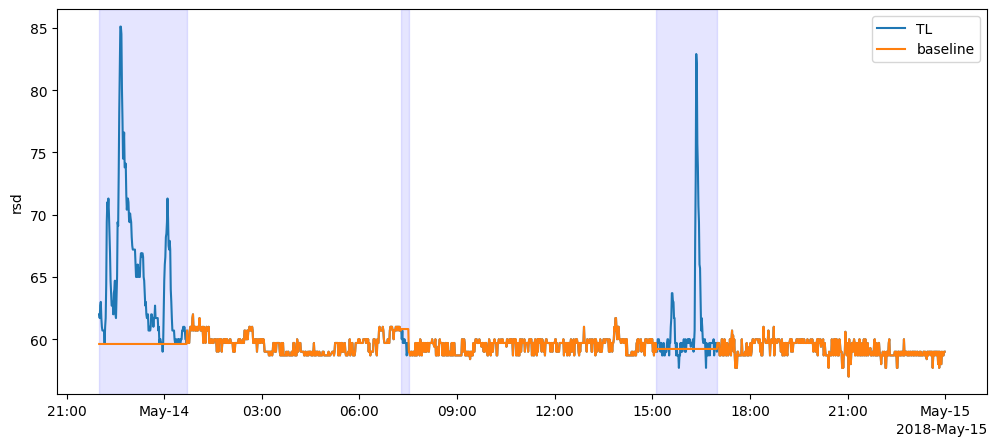

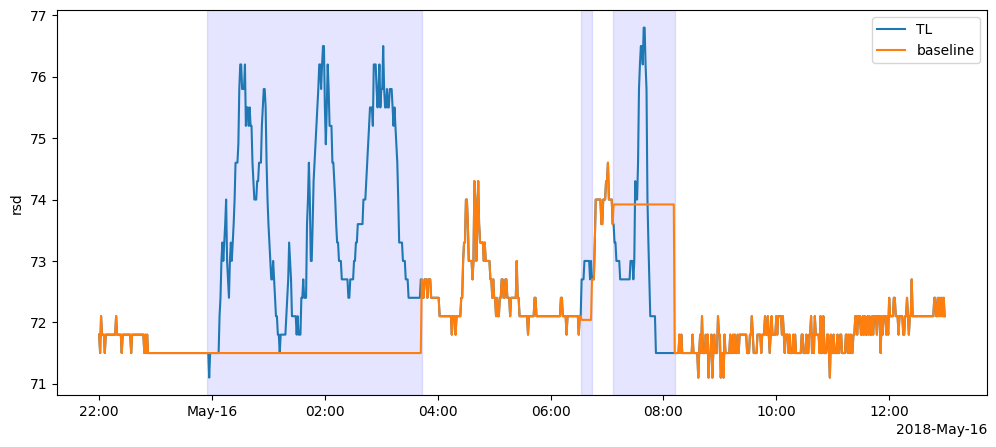

In [9]:
#cmls = xr.open_dataset(pycml.io.examples.get_example_data_path() + '/example_cml_data.nc') #cteni dat

# select 3 different CMLs to study
cmls = cmls.isel(cml_id = [0, 10, 370])

# Remove outliers, compute tl and interpolate missing values
cmls['tsl'] = cmls.tsl.where(cmls.tsl != 255.0)
cmls['rsl'] = cmls.rsl.where(cmls.rsl != -99.9)
cmls['tl'] = cmls.tsl - cmls.rsl # calculate total loss (previous TRSL)
cmls['tl'] = cmls.tl.interpolate_na(dim='time', method='linear', max_gap='5min')

# 1. wet dry detection using rsd
cmls['wet_rsd'] = cmls.tl.rolling(time=60, center=True).std() > 0.8

    # Determine baseline RSD
cmls['baseline_rsd'] = pycml.processing.baseline.baseline_constant(
    trsl=cmls.tl, 
    wet=cmls.wet_rsd, 
    n_average_last_dry=5
)


start = '2018-05-13T22'
end = '2018-05-14'
cml_plot = cmls.sel(time = slice(start, end)).isel(cml_id = 0, channel_id = 0)

# convert float to bool for plotting the shaded areas
cml_plot['wet_rsd'] = cml_plot.fillna(0).wet_rsd.astype(bool)

fig, axs = plt.subplots(figsize=(12,5))

#fig, axs = plt.subplots(1, 1, figsize=(12,5), sharex=True)
cml_plot.tl.plot.line(x='time', ax=axs, label = 'TL');

# shaded rsd
cml_plot['wet_rsd'][0] = 0 
cml_plot['wet_rsd'][-1] = 0 
wet_start = np.roll(cml_plot.wet_rsd, -1) & ~cml_plot.wet_rsd
wet_end = np.roll(cml_plot.wet_rsd, 1) & ~cml_plot.wet_rsd
for wet_start_i, wet_end_i in zip(
    wet_start.data.nonzero()[0],
    wet_end.data.nonzero()[0],
):
    axs.axvspan(cml_plot.time.data[wet_start_i], cml_plot.time.data[wet_end_i], color='b', alpha=0.1)


cml_plot.baseline_rsd.plot.line(x='time', ax=axs, label ='baseline');

axs.set_title('');
axs.set_xlabel('')

axs.set_ylabel('rsd')

axs.legend(loc = 'upper right')
plt.show()



start = '2018-05-15T22'
end = '2018-05-16T12'
cml_plot = cmls.sel(time = slice(start, end)).isel(cml_id = 2, channel_id = 0)

# convert float to bool for plotting the shaded areas
cml_plot['wet_rsd'] = cml_plot.fillna(0).wet_rsd.astype(bool)

fig, axs = plt.subplots(figsize=(12,5))
#fig, axs = plt.subplots(3, 1, figsize=(12,5), sharex=True)
cml_plot.tl.plot.line(x='time', ax=axs, label = 'TL');

# shaded rsd
cml_plot['wet_rsd'][0] = 0 
cml_plot['wet_rsd'][-1] = 0 
wet_start = np.roll(cml_plot.wet_rsd, -1) & ~cml_plot.wet_rsd
wet_end = np.roll(cml_plot.wet_rsd, 1) & ~cml_plot.wet_rsd
for wet_start_i, wet_end_i in zip(
    wet_start.data.nonzero()[0],
    wet_end.data.nonzero()[0],
):
    axs.axvspan(cml_plot.time.data[wet_start_i], cml_plot.time.data[wet_end_i], color='b', alpha=0.1)

cml_plot.baseline_rsd.plot.line(x='time', ax=axs, label ='baseline');

axs.set_title('');
axs.set_xlabel('')

axs.set_ylabel('rsd')

axs.legend(loc = 'upper right')
plt.show()

In [10]:
%matplotlib inline
import xarray as xr
cmls = xr.open_dataset(pycml.io.examples.get_example_data_path() + '/example_cml_data.nc')
radar_along_cml = xr.open_dataset(pycml.io.examples.get_example_data_path() + '/example_path_averaged_reference_data.nc')


cml = cmls.isel(cml_id=338)

cml['tsl'] = cml.tsl.where(cml.tsl != 255.0)
cml['rsl'] = cml.rsl.where(cml.rsl != -99.9)
cml['trsl'] = cml.tsl - cml.rsl
cml['trsl'] = cml.trsl.interpolate_na(dim='time', method='linear', max_gap='5min')

cml['wet'] = cml.trsl.rolling(time=60, center=True).std(skipna=False) > 0.8

cml['baseline'] = pycml.processing.baseline.baseline_constant(
    trsl=cml.trsl, 
    wet=cml.wet, 
    n_average_last_dry=5,
)

cml['A'] = cml.trsl - cml.baseline
cml['A'] = cml.A.where(cml.A >= 0, 0)

cml['waa_leijnse'] = pycml.processing.wet_antenna.waa_leijnse_2008_from_A_obs(
    A_obs=cml.A,
    f_Hz=cml.frequency,
    pol=cml.polarization,
    L_km=cml.length,
)

cml['waa_pastorek'] = pycml.processing.wet_antenna.waa_pastorek_2021_from_A_obs(
    A_obs=cml.A,
    f_Hz=cml.frequency,
    pol=cml.polarization,
    L_km=cml.length,
    A_max=5,
)

cml['waa_schleiss'] = pycml.processing.wet_antenna.waa_schleiss_2013(
    rsl=cml.trsl,
    baseline=cml.baseline,
    wet=cml.wet,
    waa_max=2.2,
    delta_t=1,
    tau=15,
)

for waa_method in ['leijnse', 'pastorek', 'schleiss']:
    cml[f'A_rain_{waa_method}'] = cml.trsl - cml.baseline - cml[f'waa_{waa_method}']
    cml[f'A_rain_{waa_method}'] = cml[f'A_rain_{waa_method}'].where(cml[f'A_rain_{waa_method}'] >= 0, 0)
    cml[f'R_{waa_method}'] = pycml.processing.k_R_relation.calc_R_from_A(
        A=cml[f'A_rain_{waa_method}'], L_km=float(cml.length), f_GHz=cml.frequency/1e9, pol=cml.polarization
    )
cml['R'] = pycml.processing.k_R_relation.calc_R_from_A(
        A=cml.trsl - cml.baseline, L_km=float(cml.length), f_GHz=cml.frequency/1e9, pol=cml.polarization,)

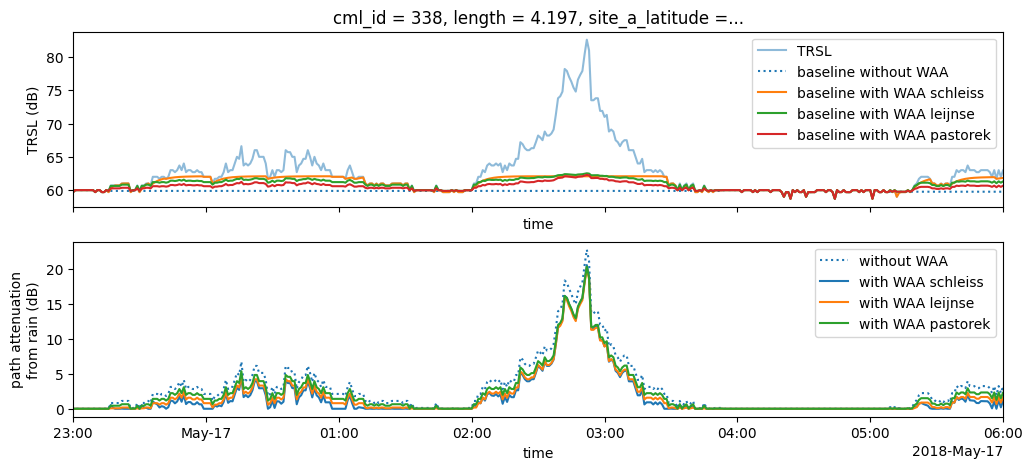

In [11]:
fig, axs = plt.subplots(2, 1, figsize=(12,5), sharex=True)

plt.sca(axs[0])
cml.isel(channel_id=0).trsl.plot.line(x='time', alpha=0.5, label='TRSL')
plt.gca().set_prop_cycle(None)
cml.isel(channel_id=0).baseline.plot.line(x='time', linestyle=':', label='baseline without WAA');
(cml.baseline + cml.waa_schleiss).isel(channel_id=0).plot.line(x='time', label='baseline with WAA schleiss');
plt.ylabel('TRSL (dB)')
(cml.baseline + cml.waa_leijnse).isel(channel_id=0).plot.line(x='time', label='baseline with WAA leijnse');
plt.ylabel('TRSL (dB)')
(cml.baseline + cml.waa_pastorek).isel(channel_id=0).plot.line(x='time', label='baseline with WAA pastorek');
plt.ylabel('TRSL (dB)')
axs[0].legend()

# estimate WAA and correct baseline
cml['A'] = cml.trsl - cml.baseline - cml.waa_schleiss
cml['A'].values[cml.A < 0] = 0
cml['B'] = cml.trsl - cml.baseline - cml.waa_leijnse
cml['B'].values[cml.B < 0] = 0
cml['C'] = cml.trsl - cml.baseline - cml.waa_pastorek
cml['C'].values[cml.C < 0] = 0
cml['A_no_waa_correct'] = cml.trsl - cml.baseline
cml['A_no_waa_correct'].values[cml.A_no_waa_correct < 0] = 0 

plt.sca(axs[1])
cml.A_no_waa_correct.isel(channel_id=0).plot.line(x='time', linestyle=':', label='without WAA');
plt.gca().set_prop_cycle(None)
cml.A.isel(channel_id=0).plot.line(x='time', label='with WAA schleiss');
cml.B.isel(channel_id=0).plot.line(x='time', label='with WAA leijnse');
cml.C.isel(channel_id=0).plot.line(x='time', label='with WAA pastorek');
plt.ylabel('path attenuation\nfrom rain (dB)');
axs[1].set_title('');
axs[1].legend()

axs[1].set_xlim(pd.to_datetime('2018-05-16 23:00:00'), pd.to_datetime('2018-05-17 06:00:00'));

In [12]:
cml['baseline'] = pycml.processing.baseline.baseline_constant(trsl=cml.trsl, wet=cml.wet, n_average_last_dry=5)

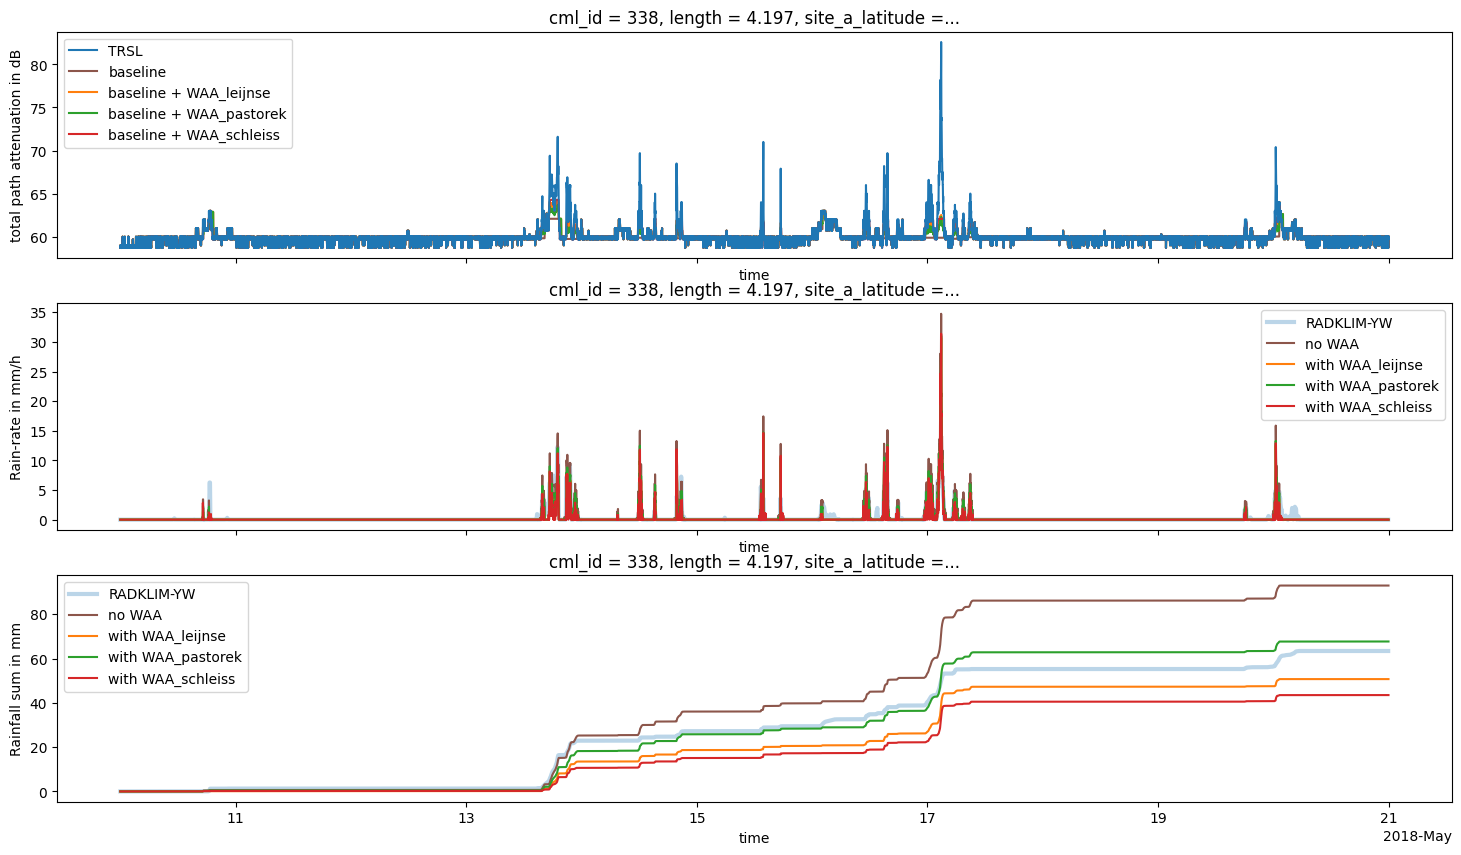

In [13]:
#%matplotlib widget
fig, axs = plt.subplots(3, 1, figsize=(18, 10), sharex=True)
plt.sca(axs[0])
cml.trsl.isel(channel_id=0).plot.line(x='time', label='TRSL', color='C0', zorder=10)
cml.baseline.isel(channel_id=0).plot.line(x='time', label='baseline', color='C5')
(cml.baseline + cml.waa_leijnse).isel(channel_id=0).plot.line(x='time', label='baseline + WAA_leijnse', color='C1')
(cml.baseline + cml.waa_pastorek).isel(channel_id=0).plot.line(x='time', label='baseline + WAA_pastorek', color='C2')
(cml.baseline + cml.waa_schleiss).isel(channel_id=0).plot.line(x='time', label='baseline + WAA_schleiss', color='C3')
plt.ylabel('total path attenuation in dB')
plt.legend()

plt.sca(axs[1])
(radar_along_cml.sel(cml_id=cml.cml_id.values).rainfall_amount * 12).plot.line(color='C0', linewidth=3.0, label='RADKLIM-YW', alpha=0.3)
cml.R.isel(channel_id=0).plot.line(x='time', label='no WAA', color='C5')
cml.R_leijnse.isel(channel_id=0).plot.line(x='time', label='with WAA_leijnse', color='C1')
cml.R_pastorek.isel(channel_id=0).plot.line(x='time', label='with WAA_pastorek', color='C2')
cml.R_schleiss.isel(channel_id=0).plot.line(x='time', label='with WAA_schleiss', color='C3')
plt.ylabel('Rain-rate in mm/h')
plt.legend()

plt.sca(axs[2])
radar_along_cml.sel(cml_id=cml.cml_id.values).rainfall_amount.cumsum(dim='time').plot.line(color='C0', linewidth=3.0, label='RADKLIM-YW', alpha=0.3)
(cml.R.isel(channel_id=0)/60).cumsum(dim='time').plot.line(x='time', label='no WAA', color='C5')
(cml.R_leijnse.isel(channel_id=0)/60).cumsum(dim='time').plot.line(x='time', label='with WAA_leijnse', color='C1')
(cml.R_pastorek.isel(channel_id=0)/60).cumsum(dim='time').plot.line(x='time', label='with WAA_pastorek', color='C2')
(cml.R_schleiss.isel(channel_id=0)/60).cumsum(dim='time').plot.line(x='time', label='with WAA_schleiss', color='C3')
plt.ylabel('Rainfall sum in mm')
plt.legend();


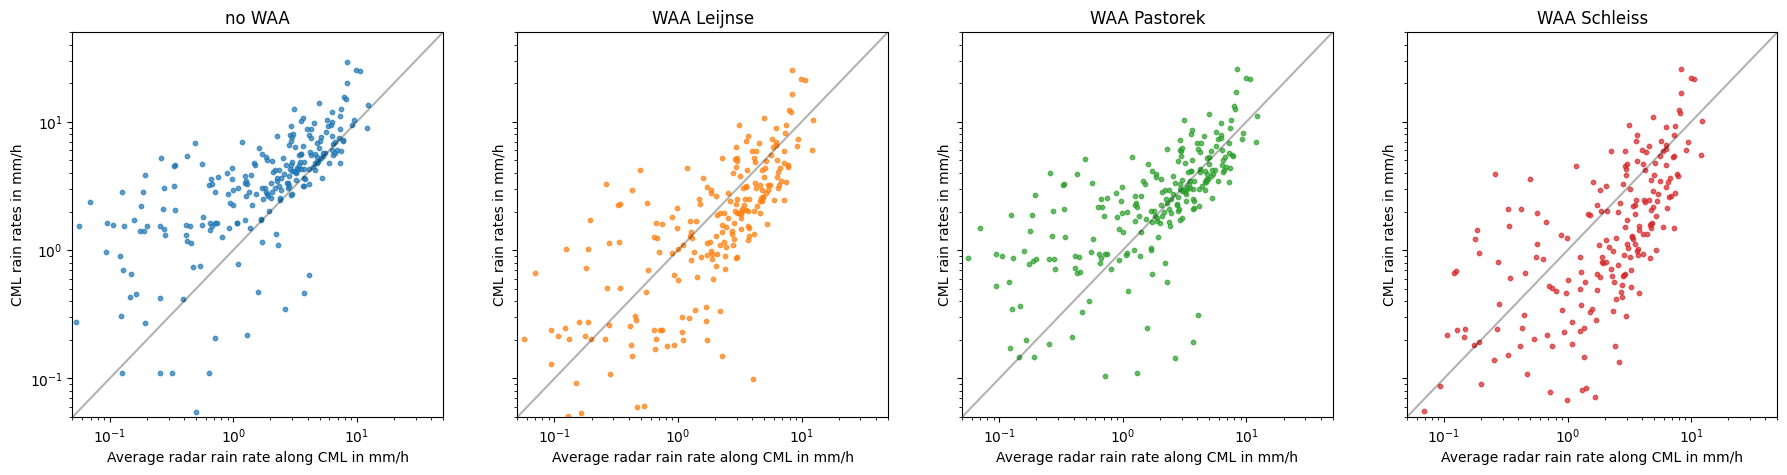

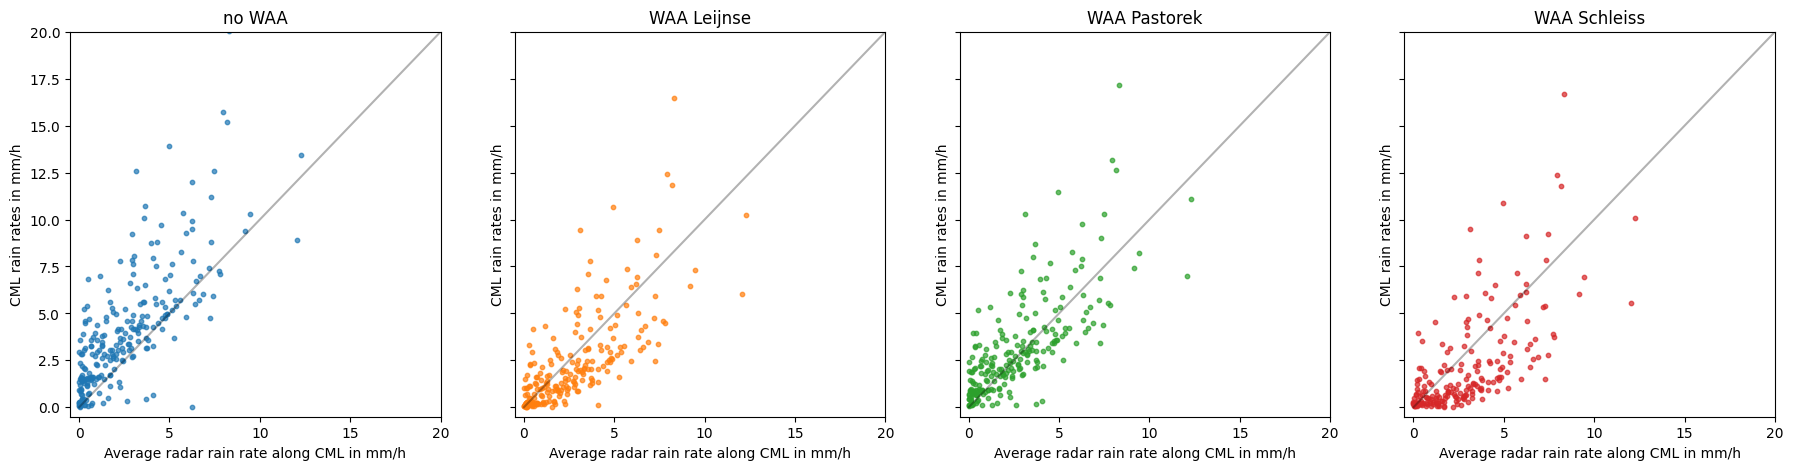

In [14]:

def hexbinplot(R_radar_along_cml, R_cml, ax, color='k', title=None, loglog=True):
    R_cml = R_cml.isel(channel_id=0).resample(time='5min').mean().reindex_like(R_radar_along_cml, method=None)
    R_cml.values[R_cml.values < 0] = 0
    #R_cml = R_cml.resample(time='1h').mean()
    #R_radar_along_cml = R_radar_along_cml.resample(time='1h').mean()
    ax.scatter(
        R_radar_along_cml.where(R_radar_along_cml > 0).values,
        R_cml.where(R_cml > 0).values,
        c=color,
        s=10,
        alpha=0.7,
    )
    if loglog:
        ax.set_xscale('log')
        ax.set_yscale('log')
    ax.set_title(title)
    ax.set_xlabel('Average radar rain rate along CML in mm/h')
    ax.set_ylabel('CML rain rates in mm/h')


R_radar_along_cml = radar_along_cml.sel(cml_id=cml.cml_id).rainfall_amount * 12

fig, axs = plt.subplots(1, 4, figsize=(22, 5), sharex=True, sharey=True)

hexbinplot(R_radar_along_cml, cml.R, axs[0], 'C0', 'no WAA')
hexbinplot(R_radar_along_cml, cml.R_leijnse, axs[1], 'C1', 'WAA Leijnse')
hexbinplot(R_radar_along_cml, cml.R_pastorek, axs[2], 'C2', 'WAA Pastorek')
hexbinplot(R_radar_along_cml, cml.R_schleiss, axs[3], 'C3', 'WAA Schleiss')

for ax in axs:
    ax.plot([0.01, 50], [0.01, 50], 'k', alpha=0.3)
    ax.set_xlim(0.05, 50)
    ax.set_ylim(0.05, 50)

fig, axs = plt.subplots(1, 4, figsize=(22, 5), sharex=True, sharey=True)

loglog=False
hexbinplot(R_radar_along_cml, cml.R, axs[0], 'C0', 'no WAA', loglog=loglog)
hexbinplot(R_radar_along_cml, cml.R_leijnse, axs[1], 'C1', 'WAA Leijnse', loglog=loglog)
hexbinplot(R_radar_along_cml, cml.R_pastorek, axs[2], 'C2', 'WAA Pastorek', loglog=loglog)
hexbinplot(R_radar_along_cml, cml.R_schleiss, axs[3], 'C3', 'WAA Schleiss', loglog=loglog)

for ax in axs:
    ax.plot([0.01, 50], [0.01, 50], 'k', alpha=0.3)
    ax.set_xlim(-0.5, 20)
    ax.set_ylim(-0.5, 20)

In [15]:

cml['R'] = pycml.processing.k_R_relation.calc_R_from_A(A=cml.A, L_km=float(cml.length), f_GHz=cml.frequency/1e9, pol=cml.polarization) #vypocet intezity deste

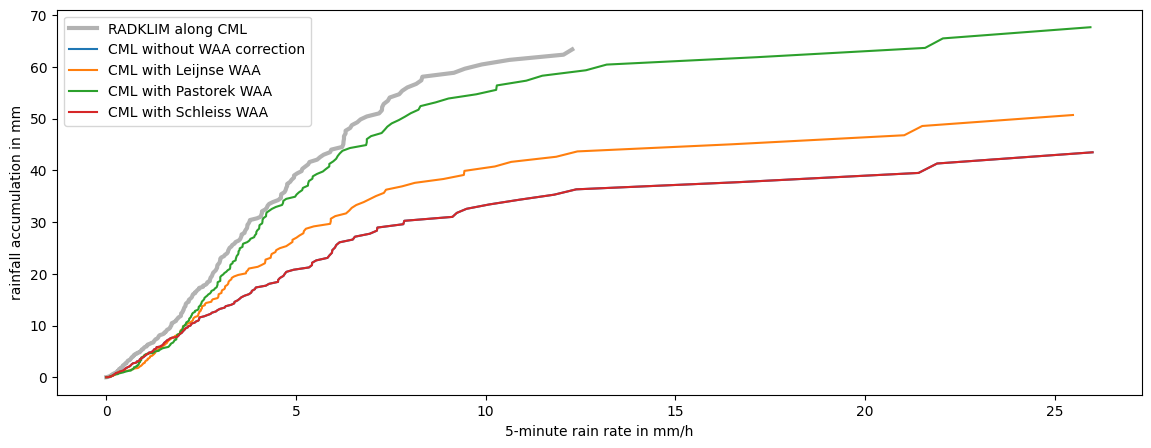

In [16]:
fig, ax = plt.subplots(figsize=(14, 5))
plt.plot(np.sort(R_radar_along_cml.values), np.sort(R_radar_along_cml.values / 12).cumsum(), label='RADKLIM along CML', color='k', alpha=0.3, linewidth=3)

R_cml = cml.R.isel(channel_id=0).resample(time='5min').mean().reindex_like(R_radar_along_cml, method=None)
plt.plot(np.sort(R_cml.values), np.sort(R_cml.values / 12).cumsum(), label='CML without WAA correction')

R_cml = cml.R_leijnse.isel(channel_id=0).resample(time='5min').mean().reindex_like(R_radar_along_cml, method=None)
plt.plot(np.sort(R_cml.values), np.sort(R_cml.values / 12).cumsum(), label='CML with Leijnse WAA')

R_cml = cml.R_pastorek.isel(channel_id=0).resample(time='5min').mean().reindex_like(R_radar_along_cml, method=None)
plt.plot(np.sort(R_cml.values), np.sort(R_cml.values / 12).cumsum(), label='CML with Pastorek WAA')

R_cml = cml.R_schleiss.isel(channel_id=0).resample(time='5min').mean().reindex_like(R_radar_along_cml, method=None)
plt.plot(np.sort(R_cml.values), np.sort(R_cml.values / 12).cumsum(), label='CML with Schleiss WAA')

plt.xlabel('5-minute rain rate in mm/h')
plt.ylabel('rainfall accumulation in mm')
plt.legend();

In [17]:
for cml in tqdm.tqdm(cml_list):
    cml['wet'] = cml.trsl.rolling(time=60, center=True).std(skipna=False) > 0.8
    
    cml['wet_fraction'] = (cml.wet==1).sum() / len(cml.time)
    
    cml['baseline'] = pycml.processing.baseline.baseline_constant(
        trsl=cml.trsl, 
        wet=cml.wet, 
        n_average_last_dry=5,
    )
    cml['waa'] = pycml.processing.wet_antenna.waa_schleiss_2013(
        rsl=cml.trsl, 
        baseline=cml.baseline, 
        wet=cml.wet, 
        waa_max=2.2, 
        delta_t=1, 
        tau=15,
    )
    cml['A'] = cml.trsl - cml.baseline - cml.waa
    
    # Note that we set A < 0 to 0 here, but it is not strictly required for 
    # the next step, because calc_R_from_A sets all rainfall rates below 
    # a certain threshold (default is 0.1) to 0. Some people might want to
    # keep A as it is to check later if there were negative numbers.
    cml['A'].values[cml.A < 0] = 0
    
    cml['R'] = pycml.processing.k_R_relation.calc_R_from_A(
        A=cml.A, L_km=float(cml.length), f_GHz=cml.frequency/1e9, pol=cml.polarization
   )

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [00:12<00:00, 40.58it/s]


In [18]:
path_ref = xr.open_dataset(data_path + '/example_path_averaged_reference_data.nc')


In [19]:
ds_cmls = xr.concat(cml_list, dim='cml_id')

In [20]:
rainsum_5min = ds_cmls.sel(channel_id="channel_1").R.resample(time="5min").sum() / 60


In [21]:
metrics = pycml.validation.stats.calc_rain_error_performance_metrics(
    rainsum_5min.values.T.flatten(),
    path_ref.rainfall_amount.values.flatten(),
    rainfall_threshold_wet=0.1)

[print(f'{metric}={value}') for metric, value in zip(metrics._fields, metrics)];

pearson_correlation=0.6834012664634781
coefficient_of_variation=8.646148144620074
root_mean_square_error=0.06931875505595712
mean_absolute_error=0.011793011431390889
R_sum_reference=12630.237843307716
R_sum_predicted=24069.548867923764
R_mean_reference=0.007973670239267292
R_mean_predicted=0.015195489416887425
false_wet_rate=0.02548173384389654
missed_wet_rate=0.1581905678537055
false_wet_precipitation_rate=0.2328701841190468
missed_wet_precipitation_rate=0.25619966292398055
rainfall_threshold_wet=0.1
N_all_pairs=1584000
N_nan_pairs=7
N_nan_reference_only=0
N_nan_predicted_only=7


In [22]:
cmls_R_1h = ds_cmls.R.resample(time='1h', label='right').mean().to_dataset()
cmls_R_1h

<xarray.Dataset> Size: 2MB
Dimensions:           (cml_id: 500, channel_id: 2, time: 264)
Coordinates:
  * cml_id            (cml_id) <U3 6kB '0' '1' '2' '3' ... '497' '498' '499'
    length            (cml_id) float64 4kB 6.179 5.673 7.52 ... 14.57 4.994
    site_a_latitude   (cml_id) float64 4kB 58.26 58.09 58.19 ... 57.77 57.07
    site_a_longitude  (cml_id) float64 4kB 1.388 1.637 1.359 ... 1.471 2.09
    site_b_latitude   (cml_id) float64 4kB 58.25 58.13 58.21 ... 57.83 57.07
    site_b_longitude  (cml_id) float64 4kB 1.304 1.59 1.461 ... 1.298 2.023
  * channel_id        (channel_id) <U9 72B 'channel_1' 'channel_2'
    frequency         (cml_id, channel_id) float64 8kB 2.491e+10 ... 2.598e+10
    polarization      (cml_id, channel_id) <U1 4kB 'V' 'V' 'H' ... 'V' 'V' 'V'
  * time              (time) datetime64[ns] 2kB 2018-05-10T01:00:00 ... 2018-...
Data variables:
    R                 (cml_id, channel_id, time) float64 2MB 0.0 0.0 ... 0.0 0.0

In [23]:
cmls_R_1h['lat_center'] = (cmls_R_1h.site_a_latitude + cmls_R_1h.site_b_latitude)/2
cmls_R_1h['lon_center'] = (cmls_R_1h.site_a_longitude + cmls_R_1h.site_b_longitude)/2

In [24]:
idw_interpolator = pycml.spatial.interpolator.IdwKdtreeInterpolator( #zaklad pro interpolaci dat
    nnear=15, 
    p=2, 
    exclude_nan=True, 
    max_distance=0.3,
)

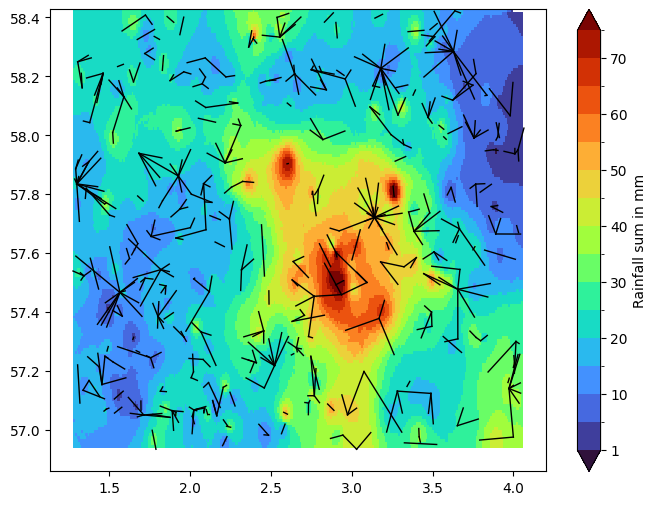

In [25]:
def plot_cml_lines(ds_cmls, ax):
    ax.plot(
        [ds_cmls.site_a_longitude, ds_cmls.site_b_longitude],
        [ds_cmls.site_a_latitude, ds_cmls.site_b_latitude],
        'k',
        linewidth=1,
    )

R_grid = idw_interpolator( #realne hodnoty pro interpolaci
    x=cmls_R_1h.lon_center, 
    y=cmls_R_1h.lat_center, 
    z=cmls_R_1h.R.isel(channel_id=1).sum(dim='time').where(ds_cmls.wet_fraction < 0.3), 
    resolution=0.01,
)

bounds = np.arange(0, 80, 5.0)
bounds[0] = 1
norm = mpl.colors.BoundaryNorm(boundaries=bounds, ncolors=256, extend='both')

fig, ax = plt.subplots(figsize=(8, 6))
pc = plt.pcolormesh(
    idw_interpolator.xgrid, 
    idw_interpolator.ygrid, 
    R_grid, 
    shading='nearest', 
    cmap='turbo',
    norm=norm,
)
plot_cml_lines(cmls_R_1h, ax=ax)
fig.colorbar(pc, label='Rainfall sum in mm');

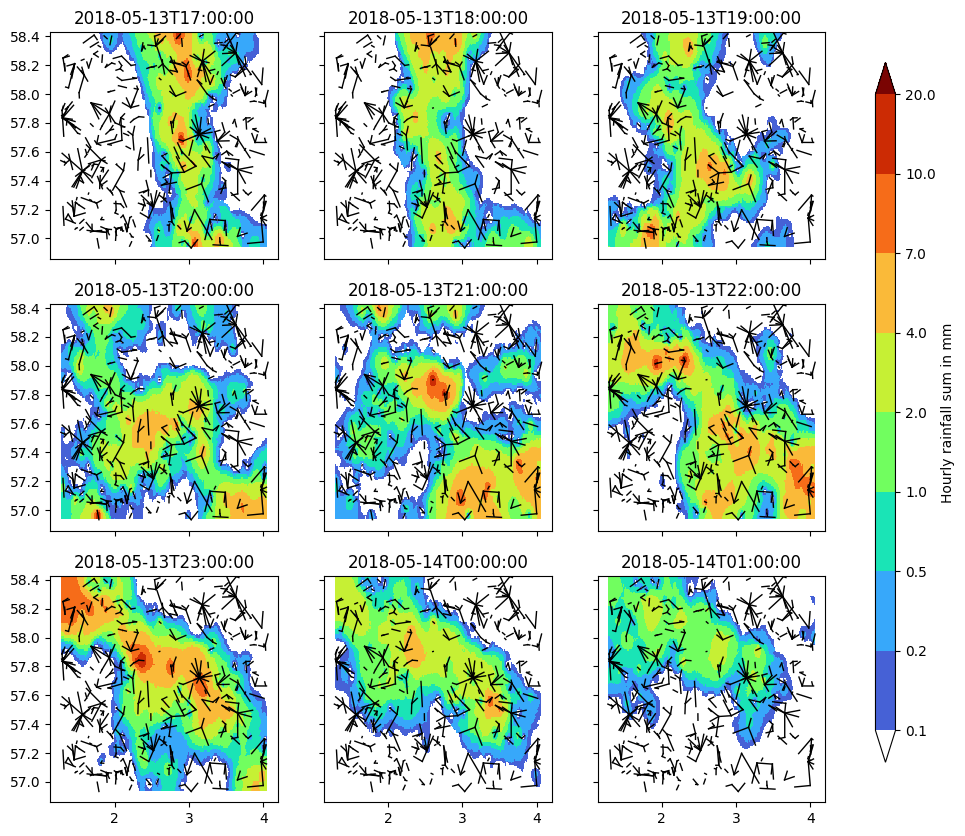

In [26]:
fig, ax = plt.subplots(3, 3, sharex=True, sharey=True, figsize=(10, 10))

bounds = [0.1, 0.2, 0.5, 1, 2, 4, 7, 10, 20] 
norm = mpl.colors.BoundaryNorm(boundaries=bounds, ncolors=256, extend='both')
cmap = plt.get_cmap('turbo').copy()
cmap.set_under('w')

for i, axi in enumerate(ax.flat):
    R_grid = idw_interpolator(
        x=cmls_R_1h.lon_center, 
        y=cmls_R_1h.lat_center, 
        z=cmls_R_1h.R.isel(channel_id=1).isel(time=i + 88).where(ds_cmls.wet_fraction < 0.3), 
        resolution=0.01,
    )
    pc = axi.pcolormesh(
        idw_interpolator.xgrid, 
        idw_interpolator.ygrid, 
        R_grid, 
        shading='nearest', 
        cmap=cmap,
        norm=norm,
    )
    axi.set_title(str(cmls_R_1h.time.values[i + 88])[:19])
    
    plot_cml_lines(cmls_R_1h, ax=axi)

fig.subplots_adjust(right=0.9)
cbar_ax = fig.add_axes([0.95, 0.15, 0.02, 0.7])
cb = fig.colorbar(pc, cax=cbar_ax, label='Hourly rainfall sum in mm', );